In [1]:
import os
import sys
import itertools
import functools
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import yaml

from lab import metrics, analytics

In [2]:
def load_distinguisher_prediction(rep: int):
    return pd.read_csv(f"../results/evaluate-split/distinguisher-predictions-{rep:02d}.csv")

def load_classifier_prediction(path_template: str, classifier: str, rep: int):
    if classifier == "varcnn":
        return (load_classifier_prediction(path_template, "varcnn-sizes", rep)
                + load_classifier_prediction(path_template, "varcnn-time", rep)) / 2
    return pd.read_csv(
        path_template.format(classifier=classifier, rep=rep),
        header=0, names=["y_true"] + list(range(-1, 100)))

def load_split_prediction(classifier: str, rep: int):
    distinguisher = pd.read_csv(f"../results/evaluate-split/distinguisher-predictions-{rep:02d}.csv")
    distinguish_proba = distinguisher["predictions"].to_numpy().reshape((-1, 1))
    
    classes = np.arange(-1, 100)
    classes_cols = [class_ for class_ in classes]
    
    # Load the QUIC and TCP Datasets
    tcp_data = load_classifier_prediction(
        "../results/evaluate-split/{classifier}-predictions-tcp-{rep:02d}.csv", classifier, rep)
    quic_data = load_classifier_prediction(
        "../results/evaluate-split/{classifier}-predictions-quic-{rep:02d}.csv", classifier, rep)
    assert(tcp_data["y_true"].equals(quic_data["y_true"]))
    assert(not tcp_data.equals(quic_data))
    
    # Extract the probabilities
    quic_proba =  quic_data[classes_cols].to_numpy()
    tcp_proba =  tcp_data[classes_cols].to_numpy()
    
    result = pd.DataFrame(distinguish_proba * quic_proba + (1-distinguish_proba) * tcp_proba,
                          index=distinguisher.index, columns=np.arange(-1, 100))
    result["y_true"] = tcp_data["y_true"]
    return result[[result.columns[-1]] + result.columns.tolist()[:-1]]

def load_split_data():
    keys = [(classifier, rep, "split") for rep in range(20)
            for classifier in ["varcnn", "p1fp", "kfp", "dfnet"]]
    return pd.concat([
        load_split_prediction(classifier, rep)
        for (classifier, rep, proto) in keys
    ], keys=keys, names=("classifier", "rep", "proto", "sample"))

def load_single_mixed_data():
    keys = [(classifier, rep, proto) for rep in range(20)
            for classifier in ["varcnn", "p1fp", "kfp", "dfnet"]
            for proto in ["quic", "tcp", "mixed"]]
    return pd.concat([
        load_classifier_prediction(
            f"../../single-and-mixed-analyses/results/dataset-performance/{{classifier}}/predictions-{proto}-{{rep:02d}}.csv", classifier, rep)
        for (classifier, rep, proto) in keys
    ], keys=keys, names=("classifier", "rep", "proto", "sample"))


def load_data():
    return pd.concat([load_split_data(), load_single_mixed_data()])


data = load_data()        
data

y_true        -1             0             1  \
classifier rep proto sample                                                 
varcnn     0   split 0         23.0  0.000698  8.564248e-18  2.115541e-06   
                     1         -1.0  0.998716  6.589761e-14  1.785410e-14   
                     2         -1.0  0.999924  1.650800e-13  6.804118e-08   
                     3         -1.0  0.999682  1.032286e-16  2.582626e-21   
                     4         -1.0  0.980665  1.385228e-10  1.703220e-14   
...                             ...       ...           ...           ...   
dfnet      19  mixed 5852      -1.0  1.000000  8.584286e-14  1.854518e-18   
                     5853      -1.0  0.999995  4.246399e-14  5.168756e-20   
                     5854      -1.0  0.999679  9.125574e-05  3.285750e-08   
                     5855      -1.0  0.839423  7.983263e-11  2.250475e-13   
                     5856      87.0  0.000010  1.300133e-14  1.839950e-08   

                                        2             3             4  \
classifier rep proto sample                                             
varcnn     0   split 0       4.232094e-19  4.591921e-13  6.334753e-16   
                     1       9.695914e-08  1.183776e-14  1.055030e-12   
                     2       5.797596e-10  3.877689e-09  1.253240e-12   
                     3       5.389388e-12  2.011897e-17  4.530022e-16   
                     4       6.724094e-07  8.568271e-07  9.233296e-08   
...                                   ...           ...           ...   
dfnet      19  mixed 5852    6.634725e-18  9.121911e-20  4.588312e-18   
                     5853    1.659138e-13  1.427675e-16  8.952736e-14   
                     5854    4.817522e-06  6.134159e-06  4.569488e-06   
                     5855    5.165064e-13  4.427298e-15  6.885049e-11   
                     5856    7.394820e-15  7.685308e-14  1.161199e-16   

                                        5             6             7  ...  \
classifier rep proto sample                                            ...   
varcnn     0   split 0       2.183288e-14  1.231799e-13  6.413175e-14  ...   
                     1       1.352398e-07  3.143887e-12  5.163191e-10  ...   
                     2       1.221910e-07  1.538959e-12  4.982860e-09  ...   
                     3       1.096579e-10  1.652977e-15  2.517495e-12  ...   
                     4       3.480719e-10  6.341631e-11  7.830011e-12  ...   
...                                   ...           ...           ...  ...   
dfnet      19  mixed 5852    3.414367e-17  1.927503e-18  5.308346e-16  ...   
                     5853    9.104907e-12  1.681496e-14  1.091539e-14  ...   
                     5854    1.405493e-07  9.596288e-11  5.676911e-11  ...   
                     5855    6.301005e-13  3.756048e-13  9.289938e-11  ...   
                     5856    2.408721e-07  1.535743e-21  4.334107e-16  ...   

                                       90            91            92  \
classifier rep proto sample                                             
varcnn     0   split 0       2.180619e-18  1.711121e-20  1.373354e-20   
                     1       3.382904e-08  2.760451e-12  1.088381e-14   
                     2       1.724733e-05  1.386594e-12  4.234519e-13   
                     3       2.772513e-07  5.881906e-20  4.279486e-16   
                     4       2.987270e-12  1.545340e-08  1.524824e-08   
...                                   ...           ...           ...   
dfnet      19  mixed 5852    1.763184e-12  4.865207e-19  1.409163e-12   
                     5853    8.877694e-18  7.231156e-18  1.053245e-14   
                     5854    3.072435e-14  1.156854e-10  6.364962e-07   
                     5855    9.170011e-12  1.067389e-16  3.052473e-11   
                     5856    1.297707e-15  1.259657e-17  5.025372e-15   

                                       93            94            95  \
classifier rep proto sample            

# Precision-Recall curve

In [3]:
def plot_pr_curve(data):
    data = (data
            .transform(lambda x: x*100)
            .sort_index()
            .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
            .rename({"precision": "$\pi_{20}$ (%)", "recall": "Recall (%)"}, axis=1)
            .rename({"mixed": "Mixed", "split": "Split", "quic": "QUIC", "tcp": "TCP"}, axis=0)
            .reset_index())

    with plt.style.context(["./mpl-style/pr-curve.mplstyle", "./mpl-style/pets.mplstyle", {"text.usetex": True}]):
        hue_order = ["TCP", "QUIC", "Mixed", "Split"]
        
        grid = sns.relplot(
            data=data, x="Recall (%)", y="$\pi_{20}$ (%)", hue="proto",
            style="proto", col="classifier", kind="line", hue_order=hue_order, height=1.125,
            aspect=1.33, facet_kws=dict(
                legend_out=True, despine=False, gridspec_kws=dict(wspace=.1)
            ), palette="binary", legend=False)
        grid.set_titles(col_template="{col_name}")
        
        for i, ax in enumerate(np.ravel(grid.axes)):
            if i == 0:
                ax.legend(labels=hue_order)
            ax.set_xticks([0, 50, 100])
            ax.set_yticks([0, 50, 100])
            ax.xaxis.get_major_formatter()._usetex = False
            ax.yaxis.get_major_formatter()._usetex = False
    return grid

/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


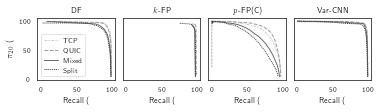

In [4]:
figure = (data.drop(columns=[-1])
          .groupby(["classifier", "proto"])
          .apply(lambda df: pd.DataFrame(analytics.rprecision_recall_curve(df["y_true"], df.drop("y_true", axis=1), ratio=20)._asdict()))
          .set_index("thresholds", append=True)
          .pipe(plot_pr_curve))

figure.savefig("../results/plots/split-classify-prcurve.pdf", dpi=150, bbox_inches="tight")
figure.savefig("../results/plots/split-classify-prcurve.pgf", dpi=150, bbox_inches="tight")

# Box Plot

In [5]:
def plot(axes, classifier, metric, frame, label: bool = False, title: bool = False):
    axes.boxplot(frame.xs([classifier, metric]).values, widths=.6, labels=frame.columns)
    if label:
        axes.set_ylabel(metric.replace("%", "\%"))
    if title:
        axes.set_title(classifier)
        
def set_ylim(axes, bottom=None, top=100, num=5):
    if bottom is None:
        bottom = axes.get_ylim()[0]
        
    lim_range = (top - bottom)
    margin = lim_range * 0.02
    
    axes.set_ylim(bottom - margin, top + margin)
    
    y_ticks = np.linspace(start=bottom, stop=top, num=num, endpoint=True, dtype=int)
    axes.set_yticks(y_ticks)

def plot_boxplots(plot_data):
    figure, axes = plt.subplots(2, 4, figsize=(6, 3), dpi=120) 

    results = {}
    for i, classifier in enumerate(plot_data.index.unique(level="classifier")[[0, 2, 1, 3]]):
        plot(axes[0][i], classifier, "$\pi_{20}$ (%)", plot_data, label=(i==0), title=True)
        plot(axes[1][i], classifier, "Recall (%)", plot_data, label=(i==0))

        for position in [0, 1]:
            axes[position][i].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.0f'))

        results[classifier] = (figure, axes[0][i], axes[1][i])

    figure.tight_layout(pad=1)

    set_ylim(results["$k$-FP"][1], 80)
    set_ylim(results["DF"][1], 20)
    set_ylim(results["$p$-FP(C)"][1], 20)
    set_ylim(results["Var-CNN"][1], 80)

    set_ylim(results["$k$-FP"][2], 92)
    set_ylim(results["DF"][2], 92)
    set_ylim(results["Var-CNN"][2], 20)
    set_ylim(results["$p$-FP(C)"][2], 20)
    
    return figure
    

In [6]:
def score(frame):
    return pd.Series({
        "precision": metrics.rprecision_score(frame["y_true"], frame["y_pred"], ratio=20),
        "recall": metrics.recall_score(frame["y_true"], frame["y_pred"])
    })

plot_data = (data.loc[:, ["y_true"]]
             .assign(y_pred=np.arange(-1, 100)[np.argmax(data.iloc[:, 1:].to_numpy(), axis=1)])
             .groupby(["classifier", "proto", "rep"])
             .apply(score)
             .stack()
             .rename_axis(index=["classifier", "factor", "repetition", "metric"])
             .unstack("factor")
             .reorder_levels([0, 2, 1])
             .rename({"tcp": "TCP", "quic": "QUIC", "mixed": "Mixed", "split": "Split"}, axis=1)
             .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0 )
             .rename({"precision": "$\pi_{20}$ (%)", "recall": "Recall (%)"}, axis=0 )
             .transform(lambda x: x*100)
             .sort_index()
             .loc[:, ["TCP", "QUIC", "Mixed", "Split"]])
plot_data

factor                                      TCP       QUIC      Mixed  \
classifier metric         repetition                                    
$k$-FP     $\pi_{20}$ (%) 0           94.660416  94.417390  92.700575   
                          1           90.899598  93.294835  86.717664   
                          2           94.278884  91.538234  89.187116   
                          3           94.273201  95.959715  90.148354   
                          4           90.071658  92.606803  94.273201   
...                                         ...        ...        ...   
Var-CNN    Recall (%)     15          66.400000  96.700000  96.900000   
                          16          96.200000  95.200000  93.100000   
                          17          45.700000  95.000000  96.900000   
                          18          96.800000  94.400000  87.500000   
                          19          71.900000  95.800000  94.800000   

factor                                    Split  
classifier metric         repetition             
$k$-FP     $\pi_{20}$ (%) 0           90.081913  
                          1           93.883089  
                          2           92.346437  
                          3           91.260689  
                          4           88.242001  
...                                         ...  
Var-CNN    Recall (%)     15          74.700000  
                          16          66.100000  
                          17          93.100000  
                          18          92.400000  
                          19          67.300000  

[160 rows x 4 columns]

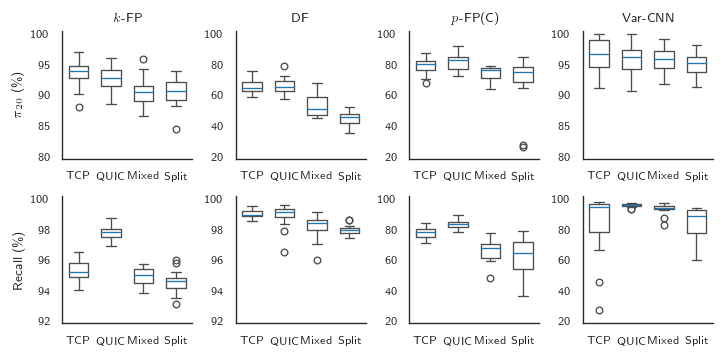

In [7]:
with plt.style.context([
    "mpl-style/white.mplstyle", "mpl-style/pets.mplstyle",  "mpl-style/box-plots.mplstyle", {"text.usetex": True}
]):
    figure = plot_boxplots(plot_data)
    figure.savefig("../results/plots/split-classify.pgf", dpi=150, bbox_inches="tight")

# Table Layout and Summary Calculations

In [8]:
table_data = plot_data.stack().unstack("classifier").reorder_levels([0, 2, 1]).sort_index(ascending=[True, False])
table_data

classifier                           $k$-FP  $p$-FP(C)         DF    Var-CNN
metric         factor repetition                                            
$\pi_{20}$ (%) TCP    0           94.660416  77.525322  71.015795  95.176437
                      1           90.899598  75.816171  61.994146  99.489185
                      2           94.278884  80.188212  64.040419  97.883089
                      3           94.273201  78.340972  61.517783  97.815713
                      4           90.071658  80.676813  68.894659  94.551725
...                                     ...        ...        ...        ...
Recall (%)     Mixed  15          95.500000  77.200000  99.100000  96.900000
                      16          95.300000  61.500000  98.900000  93.100000
                      17          94.800000  71.600000  98.200000  96.900000
                      18          94.100000  69.900000  98.400000  87.500000
                      19          95.600000  63.000000  97.700000  94.800000

[160 rows x 4 columns]

In [9]:
def to_latex_table(data, float_fmt=".1f"):
    medians = data.groupby(level=[0, 1]).median()
    iq_range = data.groupby(level=[0, 1]).quantile([0.25, 0.75])
    iq_range.index.names = iq_range.index.names[:2] + ["IQR"]
    
    columns = data.columns.values
    metrics = data.index.unique(level=0).values
    factors = data.index.unique(level=1).values
    
    result_lines = []
    result_lines.append(r"\begin{tabular}{l%s}" % ("r" * len(columns)))
    result_lines.append(r"\toprule")
    result_lines.append(r" & %s \\" % " & ".join(columns))
    result_lines.append(r"\midrule")
    
    for metric in metrics:
        result_lines.append(r"metric = %s \\" % metric.replace("%", r"\%"))
        
        for factor in factors:
            fmt_string = f"{{median:{float_fmt}}} ({{lq:{float_fmt}}}--{{uq:{float_fmt}}})"
            values = [fmt_string.format(median=median, lq=lq, uq=uq) for (median, lq, uq) in 
                      zip(medians.xs([metric, factor]).values,
                          iq_range.xs([metric, factor, 0.25]),
                          iq_range.xs([metric, factor, 0.75]))]
            values = " & ".join(values)
            result_lines.append(r"\quad %s & %s \\" % (factor, values))
    result_lines.append(r"\bottomrule")
    result_lines.append(r"\end{tabular}")
    
    return "\n".join(result_lines)

print(to_latex_table(
    table_data
    .rename({"Precision (%)": "$\pi_{20}$ (%)"})
))

\begin{tabular}{lrrrr}
\toprule
 & $k$-FP & $p$-FP(C) & DF & Var-CNN \\
\midrule
metric = $\pi_{20}$ (\%) \\
\quad TCP & 93.9 (92.8--94.7) & 80.0 (76.4--82.0) & 64.5 (62.4--68.7) & 96.7 (94.5--99.0) \\
\quad Split & 90.7 (89.1--92.2) & 75.2 (68.3--78.5) & 45.5 (41.8--47.5) & 95.2 (93.7--96.2) \\
\quad QUIC & 92.8 (91.5--94.1) & 82.7 (77.0--84.8) & 65.2 (62.6--69.1) & 96.3 (94.2--97.3) \\
\quad Mixed & 90.4 (89.0--91.5) & 75.9 (70.9--77.7) & 51.0 (47.1--58.6) & 95.8 (94.4--97.2) \\
metric = Recall (\%) \\
\quad TCP & 95.2 (94.9--95.8) & 78.3 (74.9--80.0) & 99.0 (98.9--99.2) & 94.2 (78.1--96.3) \\
\quad Split & 94.6 (94.2--94.8) & 64.7 (53.6--71.3) & 97.9 (97.8--98.1) & 88.8 (77.5--92.4) \\
\quad QUIC & 97.8 (97.5--98.0) & 83.0 (81.1--84.7) & 99.1 (98.8--99.3) & 95.8 (95.2--96.5) \\
\quad Mixed & 95.0 (94.5--95.4) & 67.4 (61.3--70.3) & 98.4 (98.0--98.6) & 93.7 (92.9--95.3) \\
\bottomrule
\end{tabular}


In [10]:
table_data.groupby(["metric", "factor"]).median()

classifier                $k$-FP  $p$-FP(C)         DF    Var-CNN
metric         factor                                            
$\pi_{20}$ (%) Mixed   90.398083  75.922781  51.041190  95.807299
               QUIC    92.791012  82.652710  65.194207  96.256786
               Split   90.658456  75.166331  45.511556  95.240812
               TCP     93.946027  80.045540  64.472632  96.719784
Recall (%)     Mixed   95.000000  67.400000  98.400000  93.650000
               QUIC    97.800000  83.050000  99.100000  95.800000
               Split   94.600000  64.650000  97.950000  88.800000
               TCP     95.200000  78.350000  98.950000  94.250000

In [11]:
idx = pd.IndexSlice

(table_data.groupby("metric").apply(analytics.median_difference, level="factor")
 .loc[idx[:, ["(Mixed - Split)", "(Split - TCP)"]], :])

classifier                        $k$-FP  $p$-FP(C)         DF   Var-CNN
metric                                                                  
$\pi_{20}$ (%) (Mixed - Split) -0.260373    0.75645   5.529634  0.566487
               (Split - TCP)   -3.287571   -4.87921 -18.961076 -1.478972
Recall (%)     (Mixed - Split)  0.400000    2.75000   0.450000  4.850000
               (Split - TCP)   -0.600000  -13.70000  -1.000000 -5.450000